In [1]:
# Set up the workspace
using SumOfSquares, JuMP, PolyJuMP, DynamicPolynomials, MultivariatePolynomials, RecursiveArrayTools, LinearAlgebra
using CSDP    # Chosen SDP solver
using Plots
gr()

include("../src/NormalSoS.jl")

Main.NormalSoS

In [2]:
# Function to construct a real, negative-definite, non-normal matrix A, of size n×n
function randsys(n)
    
    S = -rand(Float64,n) # Choose the eigenvalues
    
    S = diagm(S)
    Q = Matrix(1.0I(n))
    for ii=1:n # Choose the random normalised eigenvectors
        v = randn(Float64,n)
        v = v./norm(v)
        Q[:,ii] = v
    end
    A = Q*S*inv(Q)    # Constructs real matrix A with eigenvalues S, eigenvectors v
    println("Computed matrix A")
    
    return A
    
end

randsys (generic function with 1 method)

# Linear Examples

As a first test case we will examine the linear example of Zhou _et al._ (2012). For a linear system the dynamics is expressed in terms of a matrix $A$, and the properties of the decomposition are determined by some well known properties of this matrix.
\begin{equation}
    \dot{x} = f(x) = Ax.
\end{equation}
The decomposition of $f(x)$ is then the decomposition of $A$ as
\begin{equation}
    A = A_g + A_c,
\end{equation}
where,
\begin{equation}
    U(x) = -\frac{1}{2}x^\top A_g x.
\end{equation}
If $A$ is a normal matrix, then an orthogonal decomposition should be achieveable via a symmetric-antisymmetric decomposition. In this case the symmetric gradient matrix is given by,
\begin{equation}
    A_g = \frac{1}{2}(A+A^*).
\end{equation}
If $A$ is not normal, then the gradient matrix is given by the slightly more complicated expression:
\begin{equation}
    A_g = \frac{1}{2} \left( \int_0^\infty \exp(At) \exp(A^*t)\,\text{d}t\right)^{-1}.
\end{equation}
A useful comparison can therefore be made between this analytical expression for the quasipotential and that resulting from the SoS method for non-normal linear systems.

In [ ]:
# A 2D normal example
n = 2;    @polyvar x[1:n]
A = [-5.0 0.2;
     0.2 -1.0]
F1(X::Vector) = A*X
f1 = F1(x)
U1 = NormalSoS.normdecomp(f1,x)

# 
(λ,u) = eigen(A)
(~,v) = eigen(A')
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j])
end
V1 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x))

In [ ]:
@show(U1);    @show(V1)

In [ ]:
# A 3D normal example
n = 3;    @polyvar x[1:n]
A = [-5.0 0.0 0.2;
     0.0 -1.5 0.0;
     0.2 0.0 -1.0]
F2(X::Vector) = A*X
f2 = F2(x)
U2 = NormalSoS.normdecomp(f2,x)

(λ,u) = eigen(A)
(~,v) = eigen(A')
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j])
end
V2 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x))

In [ ]:
@show(U2);    @show(V2)

In [ ]:
# A 2D non-normal example
n = 2;    @polyvar x[1:n]
A = [-5.0 3.8;
     0.2 -1.0]
F3(X::Vector) = A*X
f3 = F3(x)
U3 = NormalSoS.normdecomp(f3,x)

(λ,u) = eigen(A)
(~,v) = eigen(A')
P = diagm(λ)
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j])
end
V3 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x))

In [ ]:
@show(U3);    @show(V3)

In [ ]:
# A 3D non-normal example from paper
n = 3;    @polyvar x[1:n]
A = [-5.0 0.0 0.2;
     0.0 -1.5 3.0;
     0.5 -5.0 -1.0]
F4(X::Vector) = A*X
f4 = F4(x)
U4 = NormalSoS.normdecomp(f4,x)

(λ,u) = eigen(A)
(~,v) = eigen(A')
M = inv(u)*v
for i=1:n, j=1:n
    M[i,j] = -M[i,j]/(λ[i]+λ[j])
end
V4 = NormalSoS.filterterms(0.25*dot(inv(u*M*inv(v))*x,x))

In [ ]:
@show(U4);    @show(V4)

In [ ]:
# Extract the matrix Ag
Ag = convert(Array,VectorOfArray(coefficients.(-differentiate(U4,x))))'

In [ ]:
# Extract the matrix Ac
Ac = convert(Array,VectorOfArray(coefficients.(f4 + differentiate(U4,x))))'

In [ ]:
# Plot a 2D slice of the three-dimensional potential
plt = NormalSoS.plotlandscape(f4,U4,x,([-3 3],[-3 3]), false);    plot(plt)

In [ ]:
# Display simulations of the 3 state system with damped oscillatory dynamics
using DifferentialEquations

u0 = [-2.5;2.5;1.0]
tspan = (0.0,10.0)
f(u,p,t) = F4(u)
prob = ODEProblem(f,u0,tspan)
sol = DifferentialEquations.solve(prob)

plt2 = plot(plot(plt), plot(sol.t,sol[1,:], label="x1"), layout=@layout([a b]),size=[900,350])
plot!(plt2[1], sol[1,:],sol[2,:], color=:black, legend=false)
plot!(plt2[2], sol.t,sol[2,:], label="x2")
plot!(plt2[2], sol.t,sol[3,:], label="x3")

## Scaling

We can reun the optimization procedure many times for randomly generated systems of varying size $n$. This allows us to see how the speed of the algorithm varies with time.

In [3]:
# Perform many optimisations in a loop to test timing and accuracy
Nvec = [2 3 4 5 6 7 8 9 10]
Tvec = zeros(length(Nvec))
Evec = zeros(length(Tvec))

for ii=1:length(Nvec)
    n = Nvec[ii]
    @polyvar x[1:n]
    A = randsys(n)
    F(X::Vector) = A*X
    fx = F(x)
    Tvec[ii] = @elapsed U = NormalSoS.normdecomp(fx,x,CSDP.Optimizer,5)
    Evec[ii] = NormalSoS.checknorm(fx,U,x)
    if isnan(Evec[ii]);    Tvec[ii] = NaN;    end
end

Computed matrix A


Chosen basis as:


Monomial{true}[x₁², x₁x₂, x₂², x₁, x₂, 1]
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 8.76e-01 Pobj:  1.2271040e+00 Ad: 8.50e-01 Dobj:  1.9330647e+01 
Iter:  2 Ap: 9.07e-01 Pobj:  1.1128079e-01 Ad: 9.34e-01 Dobj:  1.5575013e+01 
Iter:  3 Ap: 8.82e-01 Pobj:  8.5626202e-02 Ad: 8.87e-01 Dobj:  2.8926965e+00 
Iter:  4 Ap: 8.92e-01 Pobj:  3.2236602e-02 Ad: 8.74e-01 Dobj:  7.1214200e-01 
Iter:  5 Ap: 1.00e+00 Pobj:  2.2101395e-02 Ad: 8.61e-01 Dobj:  1.9563361e-01 
Iter:  6 Ap: 1.00e+00 Pobj:  2.5901566e-02 Ad: 9.07e-01 Dobj:  5.5875454e-02 
Iter:  7 Ap: 1.00e+00 Pobj:  3.1581787e-02 Ad: 8.21e-01 Dobj:  3.8206493e-02 
Iter:  8 Ap: 1.00e+00 Pobj:  3.2386044e-02 Ad: 9.67e-01 Dobj:  3.3008567e-02 
Iter:  9 Ap: 1.00e+00 Pobj:  3.2640530e-02 Ad: 1.00e+00 Dobj:  3.2708082e-02 
Iter: 10 Ap: 1.00e+00 Pobj:  3.2669947e-02 Ad: 1.00e+00 Dobj:  3.2673576e-02 
Iter: 11 Ap: 1.00e+00 Pobj:  3.2671989e-02 Ad: 1.00e+00 Dobj:  3.2671085e-02 
Iter: 12 Ap

nothing


bnd = x₁² + x₂²
value.(ϵ) = 

[0.03267235207187033, 8.988373934037952e-11]


Iter: 13 Ap: 9.60e-01 Pobj:  3.2672352e-02 Ad: 9.60e-01 Dobj:  3.2672343e-02 
Success: SDP solved
Primal objective value: 3.2672352e-02 
Dual objective value: 3.2672343e-02 
Relative primal infeasibility: 1.02e-11 
Relative dual infeasibility: 4.30e-09 
Real Relative Gap: -8.48e-09 
XZ Relative Gap: 9.68e-09 
DIMACS error measures: 1.23e-11 0.00e+00 1.26e-08 0.00e+00 -8.48e-09 9.68e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.62e-01 Pobj: -5.9542667e+00 Ad: 8.52e-01 Dobj:  1.5195013e+01 
Iter:  2 Ap: 8.82e-01 Pobj: -6.2775281e+00 Ad: 9.05e-01 Dobj:  1.5648830e+01 
Iter:  3 Ap: 8.83e-01 Pobj: -1.1352027e+00 Ad: 8.10e-01 Dobj:  5.5338162e+00 
Iter:  4 Ap: 9.12e-01 Pobj: -1.5712008e-01 Ad: 9.32e-01 Dobj:  6.3494302e-01 
Iter:  5 Ap: 9.24e-01 Pobj: -1.6496450e-02 Ad: 9.47e-01 Dobj:  7.2603226e-02 
Iter:  6 Ap: 8.83e-01 Pobj: -2.8945227e-03 Ad: 9.25e-01 Dobj:  1.0690230e-02 
Iter:  7 Ap: 9.21e-01 Pobj: -3.0053434e-04 Ad: 8.71e-0

Iter: 13 Ap: 9.59e-01 Pobj: -1.5416834e-11 Ad: 9.59e-01 Dobj: -1.5680968e-10 
Success: SDP solved
Primal objective value: -1.5416834e-11 
Dual objective value: -1.5680968e-10 
Relative primal infeasibility: 5.71e-12 
Relative dual infeasibility: 1.33e-10 
Real Relative Gap: -1.41e-10 
XZ Relative Gap: 4.68e-10 
DIMACS error measures: 8.34e-12 0.00e+00 3.48e-10 0.00e+00 -1.41e-10 4.68e-10
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.94e-01 Pobj:  3.2554054e+00 Ad: 8.54e-01 Dobj:  3.2942441e+01 
Iter:  2 Ap: 1.00e+00 Pobj:  4.4421583e-01 Ad: 9.20e-01 Dobj:  3.0018683e+01 
Iter:  3 Ap: 1.00e+00 Pobj:  4.9616973e-01 Ad: 9.10e-01 Dobj:  5.2290314e+00 
Iter:  4 Ap: 1.00e+00 Pobj:  7.5615581e-01 Ad: 9.44e-01 Dobj:  1.6940216e+00 
Iter:  5 Ap: 8.75e-01 Pobj:  1.0952429e+00 Ad: 8.05e-01 Dobj:  1.3293305e+00 
Iter:  6 Ap: 1.00e+00 Pobj:  1.1131447e+00 Ad: 8.93e-01 Dobj:  1.1472882e+00 
Iter:  7 Ap: 1.00e+00 Pobj:  1.1162722e+00 Ad: 8.28e


Chosen basis as:
Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₂², x₂x₃, x₂x₄, x₃², x₃x₄, x₄², x₁, x₂, x₃, x₄, 1]


Iter: 12 Ap: 9.60e-01 Pobj: -9.5478903e-11 Ad: 9.52e-01 Dobj: -2.1839295e-09 
Success: SDP solved
Primal objective value: -9.5478903e-11 
Dual objective value: -2.1839295e-09 
Relative primal infeasibility: 3.28e-12 
Relative dual infeasibility: 1.18e-09 
Real Relative Gap: -2.09e-09 
XZ Relative Gap: 5.05e-09 
DIMACS error measures: 5.09e-12 0.00e+00 3.02e-09 0.00e+00 -2.09e-09 5.05e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  3.5527137e-15 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.92e-01 Pobj:  3.3481436e+00 Ad: 8.70e-01 Dobj:  4.3363465e+01 
Iter:  2 Ap: 9.65e-01 Pobj:  4.6835523e-01 Ad: 9.30e-01 Dobj:  3.4344764e+01 
Iter:  3 Ap: 8.98e-01 Pobj:  3.3244797e-01 Ad: 8.95e-01 Dobj:  6.7868463e+00 
Iter:  4 Ap: 1.00e+00 Pobj:  2.8219261e-01 Ad: 9.32e-01 Dobj:  1.4766500e+00 
Iter:  5 Ap: 1.00e+00 Pobj:  3.5203163e-01 Ad: 8.05e-01 Dobj:  6.6308377e-01 
Iter:  6 Ap: 9.81e-01 Pobj:  3.9164162e-01 Ad: 8.79e-01 Dobj:  4.4723510e-01 
Iter:  7 Ap: 1.00e+00 Pobj:  3.9866754e-01 Ad: 7.94e


Chosen basis as:
Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₁x₅, x₂², x₂x₃, x₂x₄, x₂x₅, x₃², x₃x₄, x₃x₅, x₄², x₄x₅, x₅², x₁, x₂, x₃, x₄, x₅, 1]
Iter: 12 Ap: 9.60e-01 Pobj: -9.9682873e-11 Ad: 9.57e-01 Dobj: -5.5272888e-09 
Success: SDP solved
Primal objective value: -9.9682873e-11 
Dual objective value: -5.5272888e-09 
Relative primal infeasibility: 3.25e-12 
Relative dual infeasibility: 2.56e-09 
Real Relative Gap: -5.43e-09 
XZ Relative Gap: 5.82e-09 
DIMACS error measures: 5.53e-12 0.00e+00 6.31e-09 0.00e+00 -5.43e-09 5.82e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj: -3.5527137e-15 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.84e-01 Pobj:  4.8360117e+00 Ad: 8.68e-01 Dobj:  5.6089892e+01 
Iter:  2 Ap: 9.55e-01 Pobj:  6.1948158e-01 Ad: 9.28e-01 Dobj:  4.5187889e+01 
Iter:  3 Ap: 8.59e-01 Pobj:  4.4697186e-01 Ad: 8.94e-01 Dobj:  1.0086843e+01 
Iter:  4 Ap: 1.00e+00 Pobj:  3.3948615e-01 Ad: 8.99e-01 Dobj:  2.8284841e+00 
Iter:  5 Ap: 1.00e+00 Pobj:  4.1835278e-01 Ad: 8.14e-01 Dobj:  1.06

nothing
bnd = x₁² + x₂² + x₃² + x₄² + x₅²
value.(ϵ) = [0.05596365026383357, 0.010848868743444456, 2.249943842347335e-10, 0.19589099587948214, 0.25542603427099736]


Iter: 14 Ap: 9.60e-01 Pobj:  5.1812955e-01 Ad: 9.60e-01 Dobj:  5.1812953e-01 
Success: SDP solved
Primal objective value: 5.1812955e-01 
Dual objective value: 5.1812953e-01 
Relative primal infeasibility: 2.63e-14 
Relative dual infeasibility: 4.43e-09 
Real Relative Gap: -7.85e-09 
XZ Relative Gap: 8.80e-09 
DIMACS error measures: 4.26e-14 0.00e+00 1.92e-08 0.00e+00 -7.85e-09 8.80e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 6.54e-01 Pobj: -6.2280598e+00 Ad: 8.58e-01 Dobj:  4.5158959e+01 
Iter:  2 Ap: 9.59e-01 Pobj: -7.0994156e+00 Ad: 8.93e-01 Dobj:  4.6266726e+01 
Iter:  3 Ap: 9.23e-01 Pobj: -1.0617561e+00 Ad: 8.33e-01 Dobj:  1.4711821e+01 
Iter:  4 Ap: 8.69e-01 Pobj: -1.9418133e-01 Ad: 9.45e-01 Dobj:  1.4251093e+00 
Iter:  5 Ap: 8.44e-01 Pobj: -4.0847752e-02 Ad: 8.87e-01 Dobj:  2.8876986e-01 
Iter:  6 Ap: 9.21e-01 Pobj: -4.0452528e-03 Ad: 9.24e-01 Dobj:  3.0254992e-02 
Iter:  7 Ap: 9.41e-01 Pobj: -2.8261750e-04 Ad: 9.41e-0

nothing
bnd = x₁² + x₂² + x₃² + x₄² + x₅² + x₆²
value.(ϵ) = [2.0675608447540128e-10, 0.31604473222928586, 0.05702629552510155, 1.1230769092485104e-10, 4.4066955640076344e-10, 1.1548290101970338e-11]


Iter: 16 Ap: 9.59e-01 Pobj:  3.7307103e-01 Ad: 9.25e-01 Dobj:  3.7307103e-01 
Success: SDP solved
Primal objective value: 3.7307103e-01 
Dual objective value: 3.7307103e-01 
Relative primal infeasibility: 5.15e-12 
Relative dual infeasibility: 1.11e-09 
Real Relative Gap: -2.02e-09 
XZ Relative Gap: 4.32e-09 
DIMACS error measures: 8.88e-12 0.00e+00 5.24e-09 0.00e+00 -2.02e-09 4.32e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 6.09e-01 Pobj: -7.0228549e+00 Ad: 8.48e-01 Dobj:  5.2446932e+01 
Iter:  2 Ap: 9.60e-01 Pobj: -1.3597740e+01 Ad: 8.83e-01 Dobj:  5.9904117e+01 
Iter:  3 Ap: 8.19e-01 Pobj: -4.7041773e+00 Ad: 8.24e-01 Dobj:  2.2598449e+01 
Iter:  4 Ap: 9.17e-01 Pobj: -1.1041709e+00 Ad: 9.44e-01 Dobj:  2.2339957e+00 
Iter:  5 Ap: 8.22e-01 Pobj: -4.8171359e-01 Ad: 8.68e-01 Dobj:  2.6217373e-01 
Iter:  6 Ap: 7.24e-01 Pobj: -3.8811092e-01 Ad: 8.79e-01 Dobj: -2.2942009e-01 
Iter:  7 Ap: 6.09e-01 Pobj: -3.7306784e-01 Ad: 7.50e-0

Chosen basis as:
Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₁x₅, x₁x₆, x₁x₇, x₂², x₂x₃, x₂x₄, x₂x₅, x₂x₆, x₂x₇, x₃², x₃x₄, x₃x₅, x₃x₆, x₃x₇, x₄², x₄x₅, x₄x₆, x₄x₇, x₅², x₅x₆, x₅x₇, x₆², x₆x₇, x₇², x₁, x₂, x₃, x₄, x₅, x₆, x₇, 1]


Iter: 13 Ap: 9.60e-01 Pobj: -7.6160800e-11 Ad: 9.60e-01 Dobj: -1.1708710e-08 
Success: SDP solved
Primal objective value: -7.6160800e-11 
Dual objective value: -1.1708710e-08 
Relative primal infeasibility: 1.88e-11 
Relative dual infeasibility: 3.17e-09 
Real Relative Gap: -1.16e-08 
XZ Relative Gap: 8.09e-09 
DIMACS error measures: 3.68e-11 0.00e+00 7.55e-09 0.00e+00 -1.16e-08 8.09e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  1.4210855e-14 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.79e-01 Pobj:  1.0622298e+01 Ad: 8.66e-01 Dobj:  7.9113080e+01 
Iter:  2 Ap: 9.23e-01 Pobj:  1.3994375e+00 Ad: 9.38e-01 Dobj:  7.6579513e+01 
Iter:  3 Ap: 7.80e-01 Pobj:  6.0465516e-01 Ad: 8.50e-01 Dobj:  2.1884870e+01 
Iter:  4 Ap: 8.37e-01 Pobj:  1.7252134e-01 Ad: 9.20e-01 Dobj:  4.4921494e+00 
Iter:  5 Ap: 6.67e-01 Pobj:  9.4629321e-02 Ad: 6.18e-01 Dobj:  2.2630926e+00 
Iter:  6 Ap: 7.67e-01 Pobj:  4.5160453e-02 Ad: 5.34e-01 Dobj:  1.2394670e+00 
Iter:  7 Ap: 5.36e-01 Pobj:  3.6120744e-02 Ad: 8.19e


Chosen basis as:
Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₁x₅, x₁x₆, x₁x₇, x₁x₈, x₂², x₂x₃, x₂x₄, x₂x₅, x₂x₆, x₂x₇, x₂x₈, x₃², x₃x₄, x₃x₅, x₃x₆, x₃x₇, x₃x₈, x₄², x₄x₅, x₄x₆, x₄x₇, x₄x₈, x₅², x₅x₆, x₅x₇, x₅x₈, x₆², x₆x₇, x₆x₈, x₇², x₇x₈, x₈², x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, 1]


Stuck at edge of primal feasibility, giving up. 
Partial Success: SDP solved with reduced accuracy
Primal objective value: -9.9609223e-01 
Dual objective value: -1.0050227e+00 
Relative primal infeasibility: 2.10e-06 
Relative dual infeasibility: 6.39e-08 
Real Relative Gap: -2.98e-03 
XZ Relative Gap: 4.70e-07 
DIMACS error measures: 4.28e-06 0.00e+00 1.49e-07 0.00e+00 -2.98e-03 4.70e-07
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.78e-01 Pobj:  1.6499030e+01 Ad: 8.64e-01 Dobj:  9.4641739e+01 
Iter:  2 Ap: 9.62e-01 Pobj:  1.4761598e+00 Ad: 9.40e-01 Dobj:  9.6104790e+01 
Iter:  3 Ap: 7.44e-01 Pobj:  9.5797748e-01 Ad: 8.90e-01 Dobj:  2.2157928e+01 
Iter:  4 Ap: 8.79e-01 Pobj:  5.1739653e-01 Ad: 8.47e-01 Dobj:  6.3344246e+00 
Iter:  5 Ap: 9.71e-01 Pobj:  4.1969206e-01 Ad: 7.72e-01 Dobj:  2.4832387e+00 
Iter:  6 Ap: 1.00e+00 Pobj:  4.8075795e-01 Ad: 9.27e-01 Dobj:  8.1009577e-01 
Iter:  7 Ap: 1.00e+00 Pobj:  5.2871340e-01 Ad: 7.73


Chosen basis as:
Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₁x₅, x₁x₆, x₁x₇, x₁x₈, x₁x₉, x₂², x₂x₃, x₂x₄, x₂x₅, x₂x₆, x₂x₇, x₂x₈, x₂x₉, x₃², x₃x₄, x₃x₅, x₃x₆, x₃x₇, x₃x₈, x₃x₉, x₄², x₄x₅, x₄x₆, x₄x₇, x₄x₈, x₄x₉, x₅², x₅x₆, x₅x₇, x₅x₈, x₅x₉, x₆², x₆x₇, x₆x₈, x₆x₉, x₇², x₇x₈, x₇x₉, x₈², x₈x₉, x₉², x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, 1]
Stuck at edge of primal feasibility, giving up. 
Partial Success: SDP solved with reduced accuracy
Primal objective value: -9.9500878e-01 
Dual objective value: -1.0008503e+00 
Relative primal infeasibility: 1.33e-06 
Relative dual infeasibility: 3.24e-08 
Real Relative Gap: -1.95e-03 
XZ Relative Gap: 3.79e-07 
DIMACS error measures: 2.84e-06 0.00e+00 7.41e-08 0.00e+00 -1.95e-03 3.79e-07
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  2.1316282e-14 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.79e-01 Pobj:  2.0276743e+01 Ad: 8.60e-01 Dobj:  1.0397937e+02 
Iter:  2 Ap: 8.62e-01 Pobj:  3.3388580e+00 Ad: 9.41e-01 Dobj:  1.0837053e+02 
Iter:  3 Ap: 8.64e-01 Pobj:  1

nothing
bnd = x₁² + x₂² + x₃² + x₄² + x₅² + x₆² + x₇² + x₈² + x₉²
value.(ϵ) = [-4.97107910391037e-12, 0.0021647008543416446, 0.00864825669134714, 4.609087000950751e-10, 0.0585540007136858, 8.667414008733942e-11, 0.005951146357463993, 1.81301446078308e-10, 1.8766183051965868e-11]


Iter: 21 Ap: 6.84e-01 Pobj:  7.5318105e-02 Ad: 6.64e-01 Dobj:  7.5318126e-02 
Success: SDP solved
Primal objective value: 7.5318105e-02 
Dual objective value: 7.5318126e-02 
Relative primal infeasibility: 6.95e-11 
Relative dual infeasibility: 6.95e-10 
Real Relative Gap: 1.75e-08 
XZ Relative Gap: 8.22e-09 
DIMACS error measures: 1.39e-10 0.00e+00 3.93e-09 0.00e+00 1.75e-08 8.22e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 5.01e-01 Pobj: -7.4266109e+00 Ad: 8.31e-01 Dobj:  7.6317489e+01 
Iter:  2 Ap: 8.79e-01 Pobj: -1.8968870e+01 Ad: 8.40e-01 Dobj:  9.4787884e+01 
Iter:  3 Ap: 9.35e-01 Pobj: -6.4171634e+00 Ad: 8.52e-01 Dobj:  6.4233364e+01 
Iter:  4 Ap: 9.11e-01 Pobj: -1.7181559e+00 Ad: 9.50e-01 Dobj:  6.9704266e+00 
Iter:  5 Ap: 8.70e-01 Pobj: -8.8143617e-01 Ad: 8.59e-01 Dobj:  9.3642425e-01 
Iter:  6 Ap: 6.24e-01 Pobj: -7.8080806e-01 Ad: 8.71e-01 Dobj: -3.6776938e-01 
Iter:  7 Ap: 5.83e-01 Pobj: -7.6480131e-01 Ad: 7.03e-01 

Chosen basis as:
Monomial{true}[x₁², x₁x₂, x₁x₃, x₁x₄, x₁x₅, x₁x₆, x₁x₇, x₁x₈, x₁x₉, x₁x₁₀, x₂², x₂x₃, x₂x₄, x₂x₅, x₂x₆, x₂x₇, x₂x₈, x₂x₉, x₂x₁₀, x₃², x₃x₄, x₃x₅, x₃x₆, x₃x₇, x₃x₈, x₃x₉, x₃x₁₀, x₄², x₄x₅, x₄x₆, x₄x₇, x₄x₈, x₄x₉, x₄x₁₀, x₅², x₅x₆, x₅x₇, x₅x₈, x₅x₉, x₅x₁₀, x₆², x₆x₇, x₆x₈, x₆x₉, x₆x₁₀, x₇², x₇x₈, x₇x₉, x₇x₁₀, x₈², x₈x₉, x₈x₁₀, x₉², x₉x₁₀, x₁₀², x₁, x₂, x₃, x₄, x₅, x₆, x₇, x₈, x₉, x₁₀, 1]
Stuck at edge of primal feasibility, giving up. 
Partial Success: SDP solved with reduced accuracy
Primal objective value: -8.6714497e-11 
Dual objective value: -6.8346191e-06 
Relative primal infeasibility: 2.62e-08 
Relative dual infeasibility: 4.37e-09 
Real Relative Gap: -6.83e-06 
XZ Relative Gap: 1.40e-08 
DIMACS error measures: 6.74e-08 0.00e+00 9.88e-09 0.00e+00 -6.83e-06 1.40e-08
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  2.1316282e-14 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 7.70e-01 Pobj:  2.7354744e+01 Ad: 8.56e-01 Dobj:  1.1825761e+02 
Iter:  2 Ap: 8.70e-01 Pobj:  4.0469

nothing
bnd = x₁² + x₂² + x₃² + x₄² + x₅² + x₆² + x₇² + x₈² + x₉² + x₁₀²
value.(ϵ) = [4.9437315352562905e-11, 0.05908784333354755, -1.1731893234667723e-11, 6.819017572823327e-12, 5.463740571087783e-12, 2.0221768703976295e-11, 0.048358810811973046, 0.001070279194347129, 9.40483801947778e-12, -4.30999680389732e-12]


Success: SDP solved
Primal objective value: 1.0851693e-01 
Dual objective value: 1.0851707e-01 
Relative primal infeasibility: 3.41e-11 
Relative dual infeasibility: 4.86e-10 
Real Relative Gap: 1.10e-07 
XZ Relative Gap: 7.58e-09 
DIMACS error measures: 7.09e-11 0.00e+00 2.88e-09 0.00e+00 1.10e-07 7.58e-09
CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 4.68e-01 Pobj: -9.6222677e+00 Ad: 7.99e-01 Dobj:  8.7998879e+01 
Iter:  2 Ap: 7.49e-01 Pobj: -1.2591976e+02 Ad: 5.76e-01 Dobj:  1.1515089e+02 
Iter:  3 Ap: 8.80e-01 Pobj: -7.5590557e+01 Ad: 8.69e-01 Dobj:  1.1130482e+02 
Iter:  4 Ap: 9.18e-01 Pobj: -1.4913605e+01 Ad: 9.50e-01 Dobj:  4.7812311e+01 
Iter:  5 Ap: 8.58e-01 Pobj: -4.0164635e+00 Ad: 8.44e-01 Dobj:  8.1655537e+00 
Iter:  6 Ap: 8.33e-01 Pobj: -1.7502994e+00 Ad: 7.31e-01 Dobj:  2.4035776e+00 
Iter:  7 Ap: 6.52e-01 Pobj: -9.5807752e-01 Ad: 9.37e-01 Dobj:  2.8094290e-01 
Iter:  8 Ap: 3.89e-01 Pobj: -8.4959875e-01 Ad: 6.53e-01 

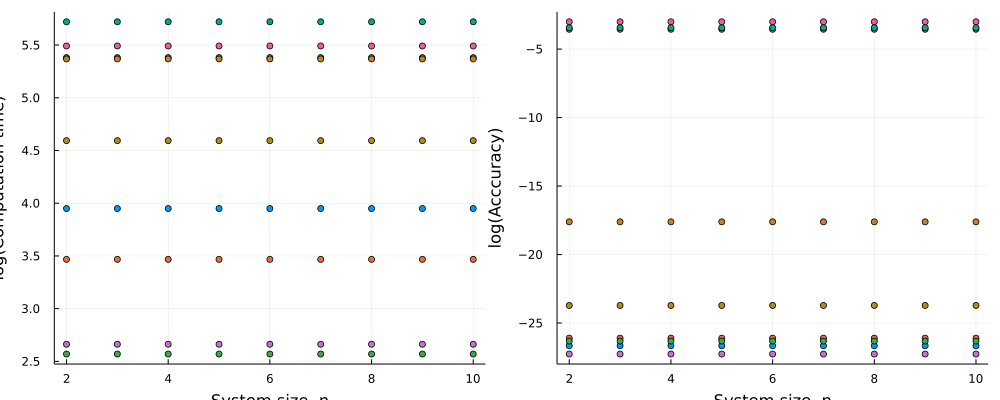

In [4]:
# Plot the computation time and accuracy against system size.
plot(scatter(Nvec',log.(Tvec'),legend=false, xlabel="System size, n",ylabel="log(Computation time)"),
     scatter(Nvec',log.(Evec'),legend=false, xlabel="System size, n",ylabel="log(Acccuracy)"),
     layout=@layout([a b]), size=[1000,400])